#  Прогнозирование заказов такси

Таксопарк собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import TimeSeriesSplit

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


(26496, 1)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


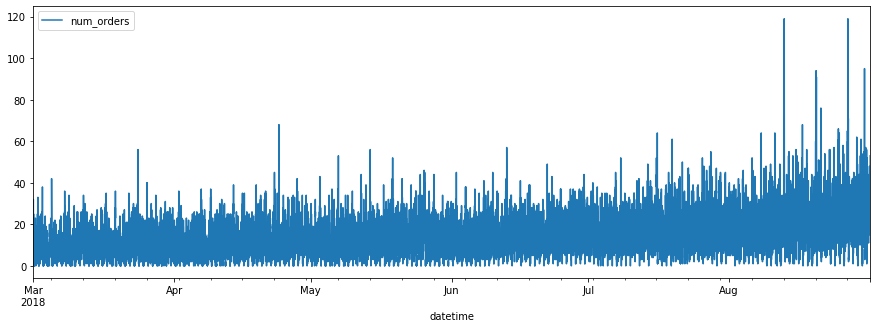

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.info()
display(df.shape)
display(df)
df.plot(figsize=(15, 5))

In [3]:
df.sort_index(inplace=True)
df_1 = df.resample('1D').sum()

Text(0.5, 1.0, 'Trend')

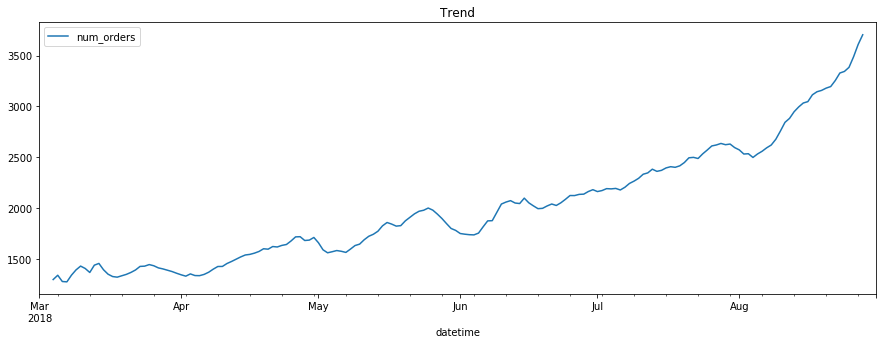

In [4]:
decomposed = seasonal_decompose(df_1)
decomposed.trend.plot(figsize=(15, 5))
plt.title('Trend')

Text(0.5, 1.0, 'Seasonality')

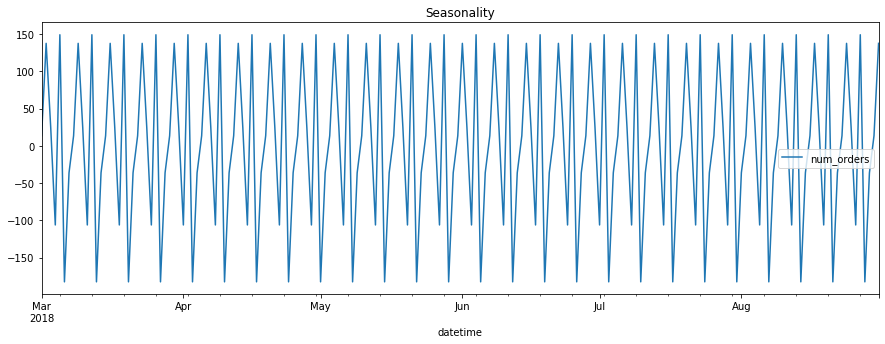

In [5]:
decomposed = seasonal_decompose(df_1)
decomposed.seasonal.plot(figsize=(15, 5))
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

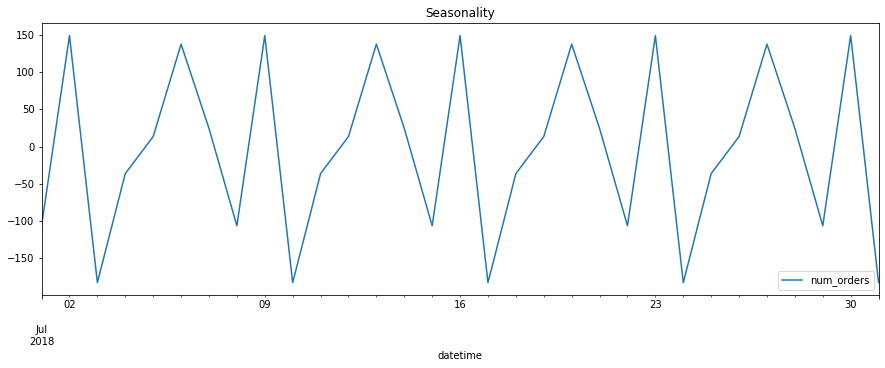

In [6]:
decomposed = seasonal_decompose(df_1)
decomposed.seasonal['2018-07-01':'2018-07-31'].plot(figsize=(15, 5))
plt.title('Seasonality')

Text(0.5, 1.0, 'Trend')

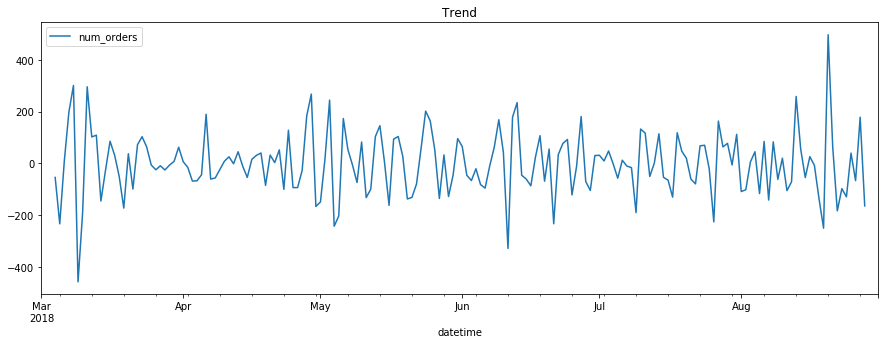

In [7]:
decomposed = seasonal_decompose(df_1)
decomposed.resid.plot(figsize=(15, 5))
plt.title('Trend')

**ВЫВОД**

Проанализировав график тренда мы видим, что количество заказов такси, начиная с апреля, заметно увеличивается, особенно в августе. Это может быть связано с наступлением сезона отпусков и ростом активности начеления по перемещению. График сезонности показывает нам зависимость между количеством заказов такси и днями недели. Более подробно проанализируем сезонность, построив график по июлю.

Мы видим, что больше всего заказов такси происходит в пятницу и понедельник, а меньше всего во втроник. Скорее всего это связано с перемещением пассажиров на выходные дни.

## Анализ

In [8]:
df = df.resample('1H').sum()
df['rolling_mean'] = df.rolling(10).mean()

Напишем функцию создания признаков для улучшения качества работы моделей.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

## Обучение

Запустим функцию make_features, разделим данные на обучающую и тестовую выборки

In [10]:
make_features(df, 6, 10)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Обучим разные модели и подберем оптимальные гиперпараметры

In [11]:
model = LinearRegression() 
model.fit(features_train, target_train)
predictions = model.predict(features_train)

print("RMSE обучающей выборки: ", mean_squared_error(target_train, predictions)**0.5)

RMSE обучающей выборки:  30.48000710682953


In [12]:
best_result = 100
best_depth = 0
for depth in range(30, 50):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_train)
    result = mean_squared_error(target_train, predictions) ** 0.5
    if result < best_result:
        best_result = result
        best_depth = depth
    
print('best_depth: ', best_depth, 'RMSE обучающей выборки: ', best_result)

best_depth:  30 RMSE обучающей выборки:  0.0


In [13]:
best_result = 100
best_est = 0
best_depth = 0
for est in range(40, 61, 10):
    for depth in range (10, 51, 10):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train) 
        predictions = model.predict(features_train) 
        result = mean_squared_error(target_train, predictions)**0.5 
        if result < best_result:
            best_result = result
            best_est = est
            best_depth = depth
            
print('best_est: ', best_est, 'best_depth: ', best_depth, 'RMSE обучающей выборки: ', best_result)

best_est:  60 best_depth:  30 RMSE обучающей выборки:  8.693000896733725


In [14]:
tscv = TimeSeriesSplit(n_splits=3)

def metric(target, predict): 
    return mean_squared_error(target, predict)**0.5

my_metric = make_scorer(metric, greater_is_better=False)

model = DecisionTreeRegressor()
parameters = {'max_depth':[30, 31, 32, 33, 34]}
 
grid = GridSearchCV(model, parameters, cv = tscv, scoring = my_metric)
grid.fit(features_train, target_train)

display(grid.best_params_)
display(grid.best_score_)

{'max_depth': 34}

-36.12153623112571

In [15]:
tscv = TimeSeriesSplit(n_splits=3)

def metric(target, predict): 
    return mean_squared_error(target, predict)**0.5

my_metric = make_scorer(metric, greater_is_better=False)

model = RandomForestRegressor()
parametrs = { 'n_estimators': range (50, 60, 70),
              'max_depth': range (30, 40, 50) }
 
grid = GridSearchCV(model, parameters, cv = tscv, scoring = my_metric)
grid.fit(features_train, target_train)

display(grid.best_params_)
display(grid.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

{'max_depth': 30}

-28.22317015680149

## Тестирование

Проверим качество работы моделей на тестовой выборке.

In [16]:
model = LinearRegression() 
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print("RMSE тестовой выборки LinearRegression: ", mean_squared_error(target_test, predictions)**0.5)

RMSE тестовой выборки LinearRegression:  53.1632088605757


In [17]:
model = DecisionTreeRegressor(max_depth=32, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print("RMSE тестовой выборки DecisionTreeRegressor: ", mean_squared_error(target_test, predictions)**0.5)

RMSE тестовой выборки DecisionTreeRegressor:  60.00656072728


In [18]:
model = RandomForestRegressor(random_state=12345, n_estimators=60, max_depth=40)
model.fit(features_train, target_train) 
predictions = model.predict(features_test) 
print("RMSE тестовой выборки RandomForestRegressor: ", mean_squared_error(target_test, predictions)**0.5)

RMSE тестовой выборки RandomForestRegressor:  45.86941069472275


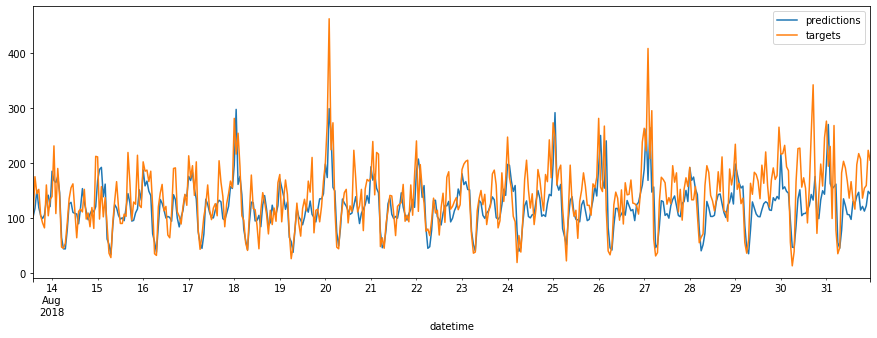

In [19]:
pd.DataFrame({'predictions': predictions, 'targets': target_test}, 
             index = target_test.index).resample('1H').sum().plot(figsize=(15, 5))

**ВЫВОД**

Лучше всего на тестовой выборке себя показала модель RandomForestRegressor. Нам удалось достичь целевого показателя RMSE. Теперь мы можем прогнозировать необходимое количество водителей такси у аэропорта в час пик.

Предварительный анализ данных позволяет нам определить дни пиковой нагрузки в зависимости от сезона, дня недели и времени суток. Эта работа позволит увеличить прибыль организаций, предоставлящих услуги такси, т.к. в при наибольшим спросе можно направить в аэропорт больше автомобилей или перераспредлить их на другие объекты при снижении спроса.